In [29]:
import requests as req
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn import metrics
import numpy as np
import re
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from funciones import getData,getNextPage,getComentarios,getEstrellas,tokenizar,crearCorpus,leerLibro,preprocesar

<br/><br/>**<u>OBTENCION DE DATOS</u>:**<br/><br/><br/><br/>

In [30]:
# Genero un array de urls de libros que vamos a utilizar.
urls = ['https://www.amazon.es/SUERTE-IDIOTAS-Novela-adictiva-acabar%C3%A1s-ebook/product-reviews/B07RBQGXVX/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
        'https://www.amazon.es/Par%C3%ADs-puede-esperar-Especial-Confinamiento-ebook/product-reviews/B087CSCB5L/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/DAMA-BLANCA-cuestionar%C3%A1-l%C3%ADmites-prohibido-ebook/product-reviews/B082PZT2KW/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/Siete-libros-para-Eva-Santiago-ebook/product-reviews/B01HVYEAA8/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/REDENCI%C3%93N-novela-revelaci%C3%B3n-Fernando-Gamboa-ebook/product-reviews/B07QW5QQM3/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/Maldici%C3%B3n-los-Montreal-misterio-suspense-ebook/product-reviews/B01HWOH1TY/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/Las-doce-puertas-Parte-I-ebook/product-reviews/B07Q6ZFN17/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       'https://www.amazon.es/soledad-CONTEMPORANEA-Gabriel-Garcia-Marquez/product-reviews/8497592204/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews',
       ]

# Con esto ya tenemos todas las reseñas y estrellas de todos los libros.
resenias = []
estrellas = []
for url in urls:
    todosLosComentarios,todasLasEstrellas = leerLibro(url)
    resenias.append(todosLosComentarios)
    estrellas.append(todasLasEstrellas)
    
# Pasamos todas las resenias a un array con una reseña por posicion.
listadoResenias = []
listadoEstrellas = []
for i,libro in enumerate(resenias): 
    for pagina in libro:
        for comentario in pagina:
            listadoResenias.append(comentario)
            
for libro in estrellas: 
    for pagina in libro:
        for valoracion in pagina:
            listadoEstrellas.append(valoracion)
            
listadoResenias = np.array(listadoResenias)
listadoEstrellas = np.array(listadoEstrellas).astype('int')

<br/><br/>**<u>ANALISIS DEL PROBLEMA</u>:**<br/><br/><br/><br/>

Nos encontramos ante un problema muy desbalanceado:


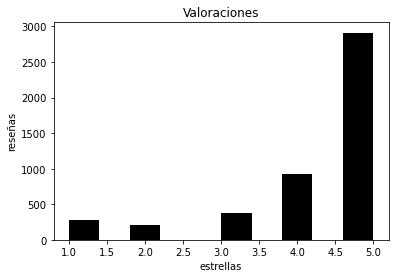

In [31]:
print("Nos encontramos ante un problema muy desbalanceado:")
plt.hist(listadoEstrellas,color = 'black')
plt.xlabel('estrellas') 
plt.ylabel('reseñas') 
plt.title("Valoraciones")
plt.show()

In [32]:
print("Tenemos {} valoraciones:".format(listadoResenias.shape[0]))
reseniasPorValoracion = []
for i in range(1,6):
    reseniasPorValoracion.append(listadoResenias[listadoEstrellas == i].shape[0])
    print("\tDe {} estrellas: {}".format(i,reseniasPorValoracion[i-1]))

Tenemos 4702 valoraciones:
	De 1 estrellas: 276
	De 2 estrellas: 210
	De 3 estrellas: 379
	De 4 estrellas: 926
	De 5 estrellas: 2911


<br/><br/>**<u>PODAR EL DATASET</u>:**<br/><br/><br/><br/>

In [33]:
listadoReseniasPodadas = listadoResenias
listadoEstrellasPodadas = listadoEstrellas
# #me quedo de cada estrella con el mismo numero de resenias, con el numero de resenias
# #que tenga la estrella que menos tiene
# listadoReseniasPodadas = []
# menosReseniasValoracion = min(reseniasPorValoracion)
# listadoEstrellasPodadas = np.empty((menosReseniasValoracion*5,))
# for valoracion in [1,2,3,4,5]:
#     aux = listadoResenias[listadoEstrellas == valoracion]
#     permutacion = np.random.permutation(aux.shape[0])
#     aux = aux[permutacion]
#     listadoReseniasPodadas += list(aux[:menosReseniasValoracion])
#     listadoEstrellasPodadas[(valoracion-1)*menosReseniasValoracion:valoracion*menosReseniasValoracion] = valoracion
# listadoReseniasPodadas = np.array(listadoReseniasPodadas)
# permutacion = np.random.permutation(listadoReseniasPodadas.shape[0])
# listadoReseniasPodadas = listadoReseniasPodadas[permutacion]
# listadoEstrellasPodadas = listadoEstrellasPodadas[permutacion]
# print("Nos hemos quedado con {} resenias balanceadas".format(listadoReseniasPodadas.shape[0]))


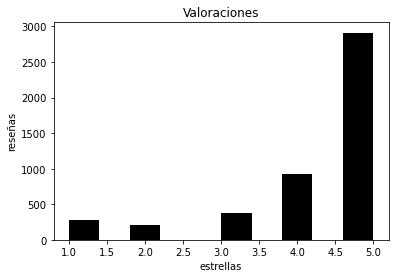

In [34]:
plt.hist(listadoEstrellasPodadas,color = 'black')
plt.xlabel('estrellas') 
plt.ylabel('reseñas') 
plt.title("Valoraciones")
plt.show()

<br/><br/>**<u>PREPROCESADO</u>:**<br/><br/><br/><br/>

In [35]:
listadoReseniasPodadas = preprocesar(listadoReseniasPodadas)

<br/><br/>**<u>STEMMIZAR</u>:**<br/><br/><br/><br/>

In [99]:
#no lo aplicamos porque baja el resultado
listadoReseniasPodadas = crearCorpus(listadoReseniasPodadas)
print(listadoReseniasPodadas[0])

 cuand junt al titul de un libr se acompañ un autobomb tan marc com este ya te hac sospech si las critic en general son tan buen tamb de tod form no pued dec que el libr sea mal es bastant distr y much mejor que otros anglosajon que idolatr com dan brownparec que hay unos parametr fij en la novel negr el protagon deb ser casi alcohol hast el punt que parec dificil que pued hac tod lo que hac con unas dosis semej de alcohol en sangr por supuest de una integr intach sin doblec nunc acept soborn ni se aprovech de las muj que se pon a tir etc etcel mal al final no parec tan idiot salv por el motiv que le muev que result increibl real es bastant list


<br/><br/>**<u>BAG OF WORDS</u>:**<br/><br/><br/><br/>

In [100]:
stop_words = set(stopwords.words('spanish'))
vectorizerDadoVocabulario = CountVectorizer(stop_words = stop_words,min_df=0.001)
bagOfWords = vectorizerDadoVocabulario.fit_transform(listadoReseniasPodadas)

<br/><br/>**<u>TFIDF</u>:**<br/><br/><br/><br/>

In [101]:
tfidf = TfidfTransformer()
bagOfWords = tfidf.fit_transform(bagOfWords)

In [126]:
print(vectorizerDadoVocabulario.get_feature_names())

['abandon', 'abiert', 'able', 'about', 'abrir', 'absolut', 'absorb', 'absorbent', 'absurd', 'abund', 'aburr', 'abus', 'acab', 'accion', 'acel', 'acept', 'acerc', 'acert', 'acev', 'aciert', 'acompañ', 'aconsej', 'acontec', 'acord', 'acostumbr', 'actos', 'actu', 'actual', 'adecu', 'adel', 'adem', 'adentr', 'adiccion', 'adict', 'adivin', 'admir', 'adolescent', 'ador', 'adqu', 'adult', 'afect', 'aficion', 'afirm', 'after', 'again', 'agent', 'agil', 'ago', 'agot', 'agrad', 'agradec', 'ahi', 'ahor', 'air', 'alarg', 'alcanz', 'alegr', 'alej', 'alert', 'algui', 'algun', 'ali', 'alici', 'alient', 'all', 'alla', 'alli', 'alma', 'alrededor', 'also', 'alt', 'altern', 'alto', 'altur', 'alucin', 'always', 'am', 'amanec', 'amant', 'amarg', 'amazing', 'amazon', 'ambient', 'ambos', 'amen', 'amer', 'americ', 'amig', 'amist', 'amor', 'ampli', 'an', 'anche', 'and', 'anecdot', 'angusti', 'anim', 'anos', 'anoth', 'ansi', 'anterior', 'anticip', 'antigu', 'any', 'anyon', 'aparec', 'aparent', 'apart', 'apasion

<br/><br/>**<u>HOLD OUT</u>:**<br/><br/><br/><br/>

In [103]:
X_train, X_test, y_train, y_test = train_test_split(bagOfWords,listadoEstrellasPodadas, stratify=listadoEstrellasPodadas,test_size=0.05,random_state=0)

<br/><br/>**<u>NB MULTINOMIAL CON HOLD OUT Y GRID SEARCH</u>:**<br/><br/><br/><br/>

In [104]:
alphas_a_probar = [1,2,3,4,5]
parameters = {'alpha': alphas_a_probar}
clf = MultinomialNB()
gridSearch = GridSearchCV(clf, param_grid = parameters, n_jobs=-1)
gridSearch = gridSearch.fit(X_train,y_train)
best_alpha = gridSearch.best_params_['alpha']
clf = MultinomialNB(alpha = best_alpha)
print("mejor alpha",best_alpha)
clf = clf.fit(X_train,y_train)
print('Con el mejor modelo de nb multinomial obtengo:')
print('\t Accuracy de entrenamiento: ', clf.score(X_train,y_train)*100)
print('\t Accuracy de test: ', clf.score(X_test,y_test)*100)

mejor alpha 1
Con el mejor modelo de nb multinomial obtengo:
	 Accuracy de entrenamiento:  65.5844155844156
	 Accuracy de test:  62.71186440677966


<br/><br/>**<u>NB MULTINOMIAL CON CROSS VALIDATE</u>:**<br/><br/><br/><br/>

In [106]:
alphas_a_probar = [0,1,2,3,4,5]
parameters = {'alpha': alphas_a_probar}
cv_results = cross_validate(MultinomialNB(), X_train, y_train, cv=60,return_estimator=True)
estimadores = cv_results['estimator']
resultadosValidacion = cv_results['test_score']
mejorEstimador = estimadores[np.argmax(resultadosValidacion)]
print(resultadosValidacion)
print(mejorEstimador.score(X_test,y_test))

[0.62666667 0.64       0.64       0.64       0.62666667 0.61333333
 0.61333333 0.62666667 0.64       0.62666667 0.62666667 0.64
 0.6        0.61333333 0.65333333 0.62666667 0.62666667 0.61333333
 0.6        0.62666667 0.68       0.61333333 0.61333333 0.61333333
 0.62666667 0.61333333 0.63513514 0.64864865 0.64864865 0.63513514
 0.66216216 0.60810811 0.60810811 0.62162162 0.60810811 0.60810811
 0.62162162 0.63513514 0.67567568 0.60810811 0.64864865 0.63513514
 0.66216216 0.67567568 0.64864865 0.66216216 0.64864865 0.63513514
 0.63513514 0.62162162 0.63513514 0.60810811 0.64864865 0.62162162
 0.63513514 0.63513514 0.64864865 0.59459459 0.64864865 0.60810811]
0.6271186440677966


<br/><br/>**<u>REGRESION LOGISTICA CON GRID SEARCH</u>:**<br/><br/><br/><br/>

In [107]:
lambda_vec = np.array([5,5.25,5.5,6,7])
c_vec = 1/lambda_vec
parameters = {'C': c_vec}
clf = LogisticRegression(max_iter=np.inf)
gridSearch = GridSearchCV(clf, param_grid = parameters, n_jobs=-1)
gridSearch = gridSearch.fit(X_train,y_train)
C_best = gridSearch.best_params_['C']
#entreno el mejor modelo
clf = LogisticRegression(C = C_best,max_iter=np.inf)
print("mejor c",C_best)
clf = clf.fit(X_train,y_train)
print('Con el mejor modelo de regresion logistica obtengo:')
print('\t Accuracy de entrenamiento: ', clf.score(X_train,y_train)*100)
print('\t Accuracy de test: ', clf.score(X_test,y_test)*100)

mejor c 0.2
Con el mejor modelo de regresion logistica obtengo:
	 Accuracy de entrenamiento:  63.927451858486336
	 Accuracy de test:  63.13559322033898


<br/><br/>**<u>SVM</u>:**<br/><br/><br/><br/>

In [108]:
from sklearn.svm import SVC
clf = SVC().fit(X_train,y_train)
print(clf.score(X_train,y_train)*100)
print(clf.score(X_test,y_test)*100)

87.03537841468875
66.52542372881356


<br/><br/>**<u>MODELO FINAL: REGRESION LOGISTICA CON PESOS 'BALANCEADOS'</u>:**<br/><br/><br/><br/>

In [110]:
#usa por debajo OVA para problemas multiclase
clf = LogisticRegression(random_state=0,max_iter=np.inf,class_weight='balanced').fit(X_train, y_train)
print(clf.score(X_test, y_test)*100)

63.559322033898304


<br/><br/>**<u>MATRIZ DE CONFUSION DE ENTRENAMIENTO</u>:**<br/><br/><br/><br/>

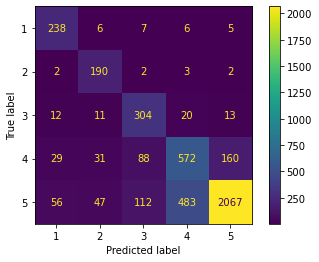

In [112]:
plot_confusion_matrix(clf, X_train, y_train);

<br/><br/>**<u>MATRIZ DE CONFUSION DE TEST</u>:**<br/><br/><br/><br/>

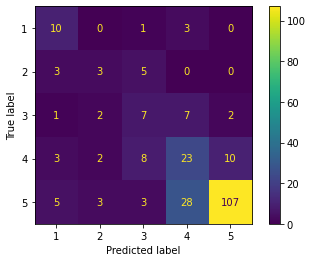

In [111]:
plot_confusion_matrix(clf, X_test, y_test);

<br/><br/>**<u>F SCORE</u>:**<br/><br/><br/><br/>

In [114]:
print(metrics.f1_score(y_test,clf.predict(X_test),average = 'micro'))

0.635593220338983


<br/><br/>**<u>PRECISION</u>:**<br/><br/><br/><br/>

In [115]:
print(metrics.precision_score(y_test,clf.predict(X_test),average = 'weighted'))

0.6941816790243845


<br/><br/>**<u>RECALL</u>:**<br/><br/><br/><br/>

In [116]:
print(metrics.recall_score(y_test,clf.predict(X_test),average = 'weighted'))

0.635593220338983


<br/><br/>**<u>AUC ROC</u>:**<br/><br/><br/><br/>

In [129]:
from sklearn.preprocessing import OneHotEncoder
transformadorYTest = OneHotEncoder()
OHE_y_test = transformadorYTest.fit_transform(y_test.reshape(-1,1)).toarray()

In [130]:
print(metrics.roc_auc_score(OHE_y_test,clf.predict_proba(X_test),multi_class='ovr',average='weighted',labels = clf.classes_))

0.8214290873253206
